In [ ]:
# Import library
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# ======================================
# 1. Persiapan Data
# ======================================

# Memuat data dari file CSV
file_path = '/content/car.data'
data = pd.read_csv(file_path, header=None)

In [ ]:
# Encode fitur kategori menjadi angka
label_encoders = [LabelEncoder() for _ in range(data.shape[1])]
for i in range(data.shape[1]):
    data[i] = label_encoders[i].fit_transform(data[i])

In [ ]:
# Memisahkan fitur (X) dan target (y)
X = data.iloc[:, :-1].values  # Semua kolom kecuali kolom terakhir
y = data.iloc[:, -1].values   # Kolom terakhir adalah target


In [ ]:
# Normalisasi fitur
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
# Membagi dataset menjadi data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Mengonversi data menjadi tensor PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [ ]:
# ======================================
# 2. Definisi Model
# ======================================

# Kelas untuk membuat model MLP
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, activation):
        super(MLPModel, self).__init__()
        layers = []
        for hidden_size in hidden_sizes:
            # Menambahkan lapisan tersembunyi
            layers.append(nn.Linear(input_size, hidden_size))
            # Menentukan fungsi aktivasi
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'softmax':
                layers.append(nn.Softmax(dim=1))
            input_size = hidden_size
        # Menambahkan lapisan output
        layers.append(nn.Linear(input_size, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [ ]:
# Fungsi untuk melatih dan mengevaluasi model
def train_and_evaluate(hidden_layers, activation, epochs, learning_rate, batch_size):
    # Membuat model dengan konfigurasi tertentu
    model = MLPModel(input_size=X_train.shape[1], hidden_sizes=hidden_layers, activation=activation)
    criterion = nn.MSELoss()  # Mean Squared Error loss untuk regresi
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Membuat DataLoader untuk batching
    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Loop pelatihan
    model.train()
    for epoch in range(epochs):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()  # Reset gradien
            outputs = model(batch_X)  # Prediksi
            loss = criterion(outputs, batch_y)  # Hitung loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update bobot

    # Evaluasi model
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor).numpy()
        mse = mean_squared_error(y_test, predictions)  # Menghitung MSE
    return mse

In [ ]:
# ======================================
# 3. Eksperimen dan Perbandingan
# ======================================

# Daftar konfigurasi parameter yang akan diuji
hidden_layer_configs = [[4], [8], [16], [4, 4], [8, 8], [16, 16], [4, 4, 4], [8, 8, 8], [16, 16, 16]]
activations = ['relu', 'sigmoid', 'tanh']
epochs_list = [1, 10, 25, 50, 100, 250]
learning_rates = [10, 1, 0.1, 0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64, 128, 256, 512]

In [ ]:
# Lakukan pencarian awal dengan epoch rendah
initial_epochs = 10
for hidden_layers, activation, _, lr, batch_size in itertools.product(hidden_layer_configs, activations, [initial_epochs], learning_rates, batch_sizes):
    mse = train_and_evaluate(hidden_layers, activation, initial_epochs, lr, batch_size)
    results.append({
        'Hidden Layers': hidden_layers,
        'Activation': activation,
        'Epochs': initial_epochs,
        'Learning Rate': lr,
        'Batch Size': batch_size,
        'MSE': mse
    })

In [ ]:
results_df = pd.DataFrame(results)

<ipython-input-18-26f6ccd4a537>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x='Hidden Layers', y='MSE', palette='Set3')


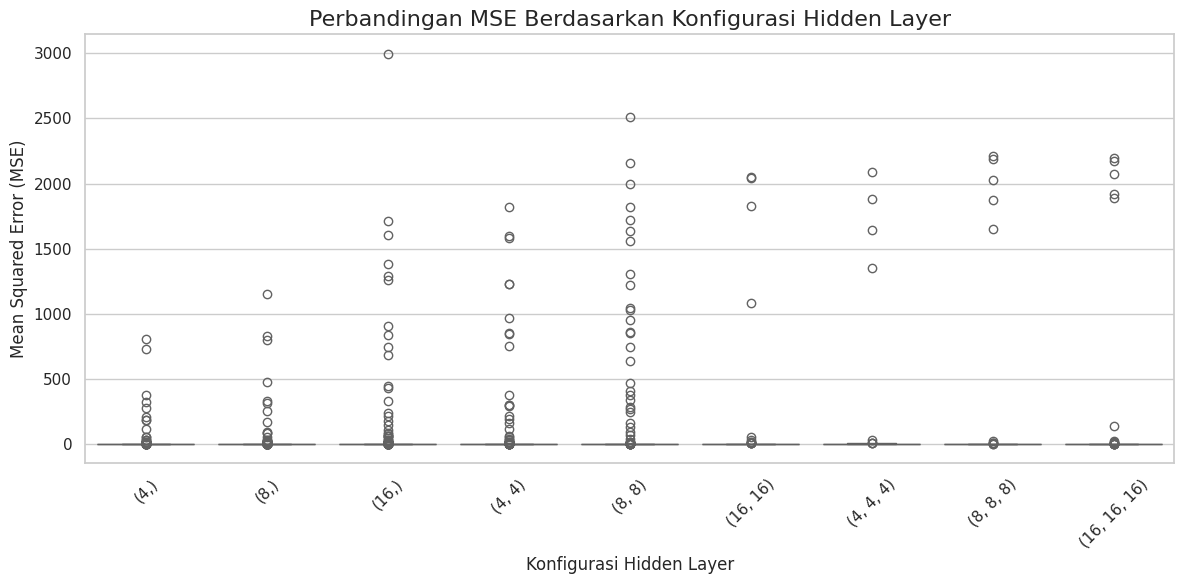

In [ ]:
# Convert 'Hidden Layers' to string representation before plotting
results_df['Hidden Layers'] = results_df['Hidden Layers'].astype(str)

# Visualisasi: MSE vs Hidden Layers
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='Hidden Layers', y='MSE', palette='Set3')
plt.title('Perbandingan MSE Berdasarkan Konfigurasi Hidden Layer', fontsize=16)
plt.xticks(rotation=45)
plt.xlabel('Konfigurasi Hidden Layer', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.tight_layout()
plt.show()

<ipython-input-19-1b910936dade>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x='Activation', y='MSE', palette='Set2')


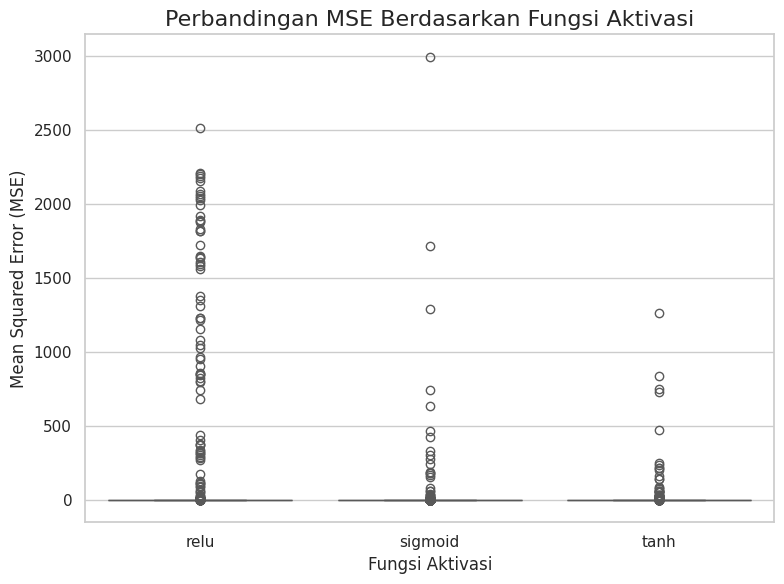

In [ ]:
# Visualisasi: MSE vs Activation Functions
plt.figure(figsize=(8, 6))
sns.boxplot(data=results_df, x='Activation', y='MSE', palette='Set2')
plt.title('Perbandingan MSE Berdasarkan Fungsi Aktivasi', fontsize=16)
plt.xlabel('Fungsi Aktivasi', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.tight_layout()
plt.show()

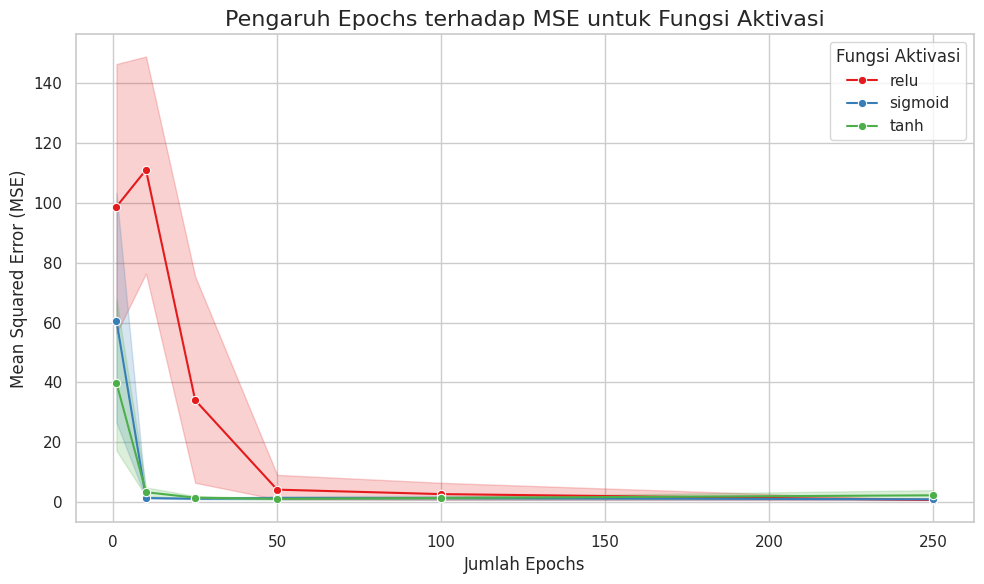

In [ ]:
# Visualisasi: MSE vs Epochs
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='Epochs', y='MSE', marker='o', hue='Activation', palette='Set1')
plt.title('Pengaruh Epochs terhadap MSE untuk Fungsi Aktivasi', fontsize=16)
plt.xlabel('Jumlah Epochs', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.legend(title='Fungsi Aktivasi')
plt.tight_layout()
plt.show()

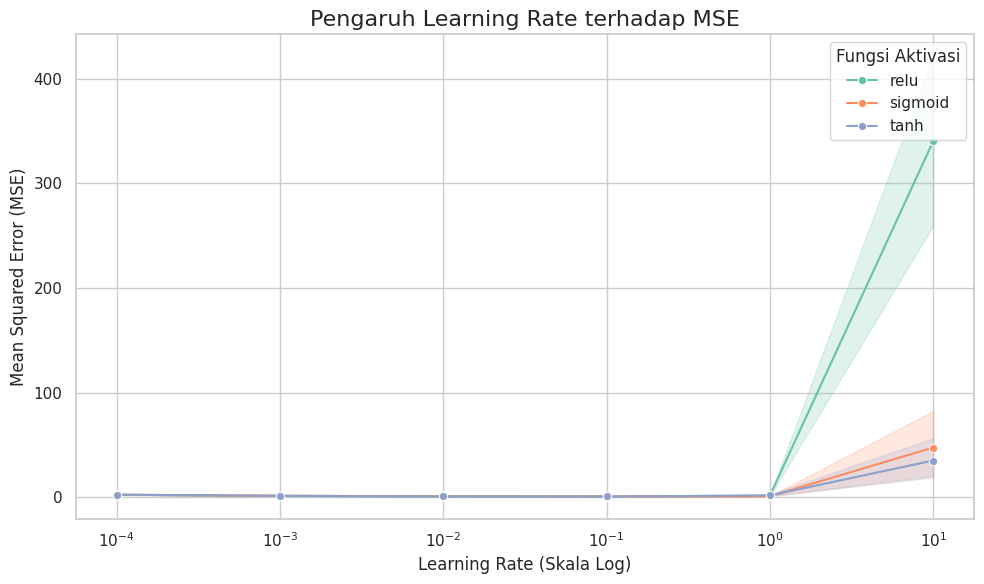

In [ ]:
# Visualisasi: MSE vs Learning Rate
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='Learning Rate', y='MSE', marker='o', hue='Activation', palette='Set2')
plt.title('Pengaruh Learning Rate terhadap MSE', fontsize=16)
plt.xscale('log')
plt.xlabel('Learning Rate (Skala Log)', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.legend(title='Fungsi Aktivasi')
plt.tight_layout()
plt.show()

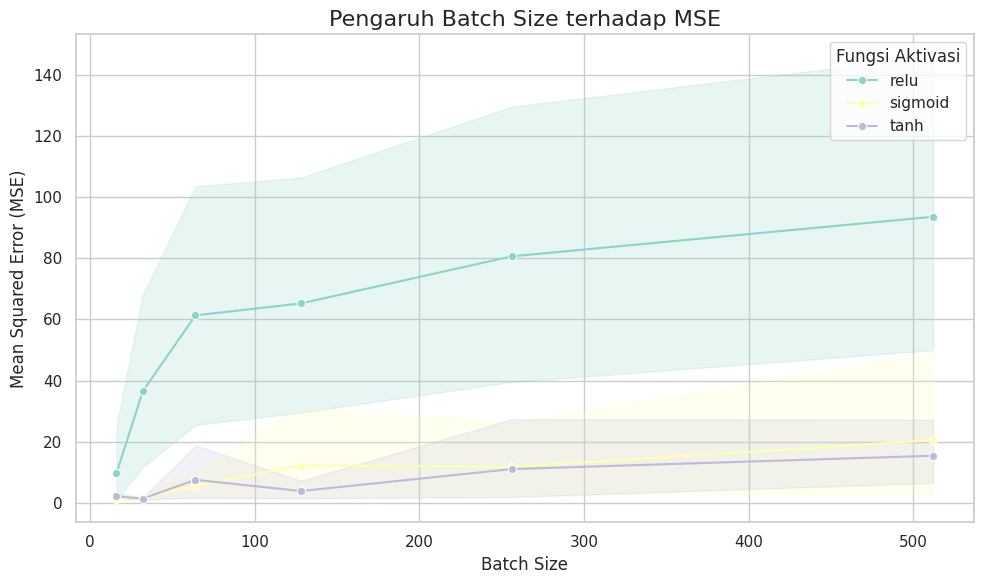

In [ ]:
# Visualisasi: MSE vs Batch Size
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='Batch Size', y='MSE', marker='o', hue='Activation', palette='Set3')
plt.title('Pengaruh Batch Size terhadap MSE', fontsize=16)
plt.xlabel('Batch Size', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.legend(title='Fungsi Aktivasi')
plt.tight_layout()
plt.show()

In [ ]:
# Menentukan kombinasi terbaik berdasarkan MSE terendah
best_result = results_df.loc[results_df['MSE'].idxmin()]

# Menampilkan konfigurasi terbaik
print("Konfigurasi Terbaik:")
print(f"  Hidden Layers: {best_result['Hidden Layers']}")
print(f"  Activation Function: {best_result['Activation']}")
print(f"  Epochs: {best_result['Epochs']}")
print(f"  Learning Rate: {best_result['Learning Rate']}")
print(f"  Batch Size: {best_result['Batch Size']}")
print(f"  Mean Squared Error (MSE): {best_result['MSE']:.4f}")

Konfigurasi Terbaik:
  Hidden Layers: (8, 8)
  Activation Function: sigmoid
  Epochs: 100
  Learning Rate: 0.1
  Batch Size: 64
  Mean Squared Error (MSE): 0.1252
